<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Wavelet_Transform_LSTM_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Using Wavelet Transform and Deep Learning: Comparing LSTM and CNN-LSTM Models

Predicting stock prices is a challenging yet fascinating problem that combines time series analysis with modern deep learning techniques. To begin, I downloaded Apple’s stock data from January 22, 2020, to May 22, 2025, using the yfinance library, which provides comprehensive historical market data. Stock market data is often noisy and volatile, which can confuse prediction models. To address this, I combined wavelet transform—a powerful signal processing tool—with two popular neural network architectures: LSTM and CNN-LSTM. In this blog, I will walk through the entire process, from data acquisition and preprocessing to model training and evaluation, highlighting how wavelet transform helps extract meaningful features and how the models compare in forecasting Apple (AAPL) stock prices.


Wavelet transform is especially useful for financial time series because it decomposes the data into different frequency components, allowing us to isolate trends and remove noise without losing important information. By applying wavelet transform to the stock price data, I extracted smoother approximation coefficients that capture the underlying patterns more clearly. This preprocessing step improves the models’ ability to learn and predict, making the forecasts more reliable compared to using raw noisy data.


After training and testing both models, I evaluated their performance using Mean Squared Error (MSE) and R-squared (R²) metrics. The LSTM model achieved a Mean Squared Error of 464.13 and an R-squared score of 0.82, indicating strong predictive power. In contrast, the CNN-LSTM model had a higher MSE of 1208.79 and a lower R-squared of 0.53, suggesting that while it captured some patterns, it was less accurate on this dataset.

The LSTM model outperformed the CNN-LSTM because it is specifically designed to capture temporal dependencies in time series data, which is crucial for stock price forecasting. The CNN-LSTM’s added complexity, combining convolutional and LSTM layers, may have led to overfitting or ineffective learning given the dataset size and characteristics. Additionally, the CNN component might not have extracted meaningful features for this type of data, reducing overall accuracy. This highlights the importance of matching model architecture to the data’s underlying patterns for optimal performance.



## Installing Required Libraries and Importing Dependencies

First, I install and import all necessary libraries including PyWavelets for wavelet transforms, yfinance to fetch stock data, and TensorFlow/Keras for deep learning modeling.

In [14]:
!pip install PyWavelets

import numpy as np
import pandas as pd
import yfinance as yf
import pywt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout, Dense
from sklearn.metrics import mean_squared_error, r2_score


## Downloading and Preparing the Stock Data

 I downloaded Apple’s stock price data (AAPL) from January 22, 2020, to May 22, 2025, using yfinance. Any missing values were forward-filled to maintain continuity. Next, I scaled the closing prices between 0 and 1 to facilitate faster and more stable model training

In [3]:
aapl_data = yf.download('AAPL', start='2020-01-22', end='2025-05-22')
aapl_data.ffill(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_data['Close'].values.reshape(-1, 1))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Applying Wavelet Transform to Extract Features


In [15]:
def wavelet_transform(data):
    """
    Apply Discrete Wavelet Transform (DWT) to scaled time series data to extract
    approximation coefficients for denoising and trend extraction.

    Mathematical details:
    ---------------------
    The signal x(t) is decomposed into approximation (A_j) and detail (D_j) coefficients:

        A_j[n] = Σ_k x[k] * ϕ_{j,n}[k]   # approximation coefficients (low-frequency)
        D_j[n] = Σ_k x[k] * ψ_{j,n}[k]   # detail coefficients (high-frequency)

    where:
      ϕ(t) is the scaling function (low-pass filter)
      ψ(t) is the wavelet function (high-pass filter)

    The decomposition is performed up to level 3 using Daubechies-1 (db1) wavelet,
    which is also known as the Haar wavelet. We retain the level-3 approximation
    coefficients (cA3) representing the denoised trend component of the data.
    """

    coeffs = pywt.wavedec(data, 'db1', level=3)  # Decompose signal into coefficients
    cA3 = coeffs[0]  # Extract level-3 approximation coefficients (trend info)
    return cA3

wavelet_data = wavelet_transform(scaled_data)



/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


## Creating Sequences for Model Training

Deep learning models like LSTM require sequential data inputs. I create sequences of length 20 from the wavelet-transformed data, where each sequence is paired with the following value as the label.

In [16]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(wavelet_data, seq_length)


## Splitting Data and Reshaping for Model Input

The data is split 80% for training and 20% for testing. Since the models expect 3D input (samples, time steps, features), I reshape the input accordingly.

In [17]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## Building and Training the LSTM Model

The LSTM model includes one LSTM layer with 50 units, a dropout layer to prevent overfitting, and a dense output layer to predict the stock price.

In [18]:
lstm_model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6936
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0270
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0190
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0201
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0169
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0164
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0155
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0163


## Building and Training the CNN-LSTM Model

The CNN-LSTM model starts with a 1D convolution layer that extracts local features, followed by max pooling and dropout. The LSTM layer captures temporal dependencies before the final prediction.

In [19]:
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2664
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0295
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0195
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0213
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0164
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0173


## Predicting the Next 10 Days

I wrote a helper function that iteratively predicts the next day's price using the model’s output as input for subsequent predictions, enabling a 10-day forecast.

In [20]:
def predict_next_days(model, last_sequence, days=10):
    predictions = []
    current_input = last_sequence.reshape(1, seq_length, 1)
    for _ in range(days):
        pred = model.predict(current_input)
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
    return np.array(predictions)

last_20_days = wavelet_data[-seq_length:]

lstm_10_days_prediction = predict_next_days(lstm_model, last_20_days)
cnn_lstm_10_days_prediction = predict_next_days(cnn_lstm_model, last_20_days)

lstm_10_days_prediction = scaler.inverse_transform(lstm_10_days_prediction.reshape(-1, 1))
cnn_lstm_10_days_prediction = scaler.inverse_transform(cnn_lstm_10_days_prediction.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


## Evaluating Model Performance

I predict on the test set and calculate Mean Squared Error (MSE) and R-squared (R²) to assess model accuracy.

In [21]:

lstm_predictions = lstm_model.predict(X_test)
cnn_lstm_predictions = cnn_lstm_model.predict(X_test)

lstm_predicted_values = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
cnn_lstm_predicted_values = scaler.inverse_transform(cnn_lstm_predictions.reshape(-1, 1))
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_mse = mean_squared_error(actual_values, lstm_predicted_values)
cnn_lstm_mse = mean_squared_error(actual_values, cnn_lstm_predicted_values)
lstm_r2 = r2_score(actual_values, lstm_predicted_values)
cnn_lstm_r2 = r2_score(actual_values, cnn_lstm_predicted_values)

evaluation_table = pd.DataFrame({
    'Model': ['LSTM', 'CNN-LSTM'],
    'Mean Squared Error (MSE)': [f'{lstm_mse:.4f}', f'{cnn_lstm_mse:.4f}'],
    'R-squared (R²)': [f'{lstm_r2:.4f}', f'{cnn_lstm_r2:.4f}']
})

print("\nEvaluation Metrics:")
print(evaluation_table.to_string(index=False))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

Evaluation Metrics:
   Model Mean Squared Error (MSE) R-squared (R²)
    LSTM                1424.9436         0.4444
CNN-LSTM                 856.8748         0.6659


## Visualizing the Results

The following plot compares actual stock prices with predictions from both models over the test period, including the 10-day forecast shaded for clarity.


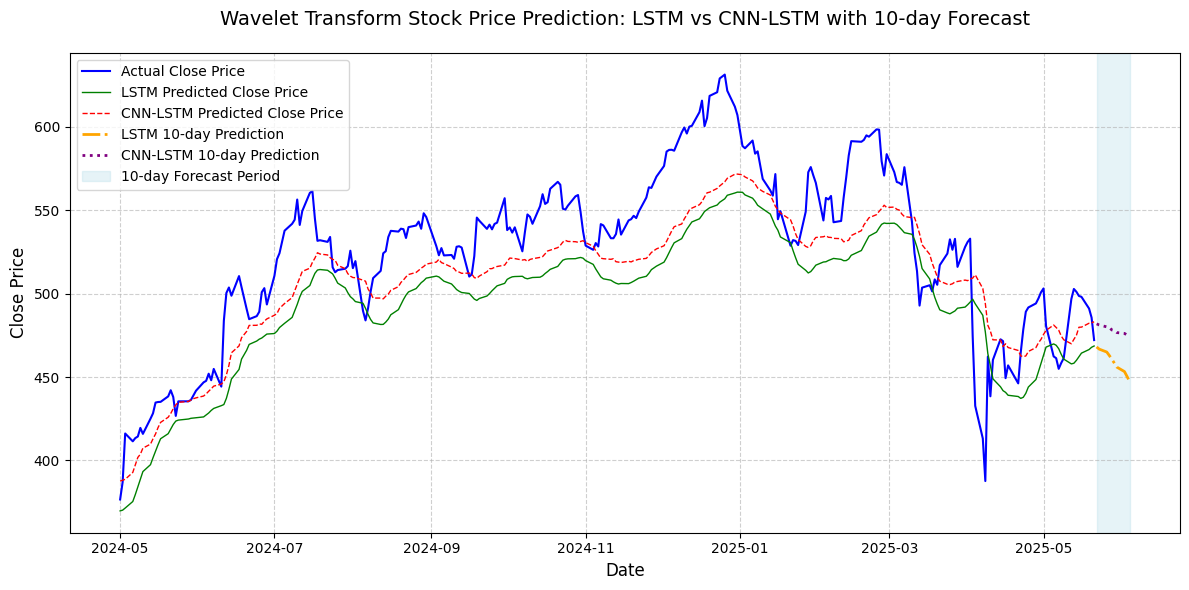

In [23]:
date_index = aapl_data.index[-len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(date_index, actual_values, label='Actual Close Price', color='blue', linewidth=1.5)
plt.plot(date_index, lstm_predicted_values, label='LSTM Predicted Close Price', color='green', linestyle='-', linewidth=1)
plt.plot(date_index, cnn_lstm_predicted_values, label='CNN-LSTM Predicted Close Price', color='red', linestyle='--', linewidth=1)

forecast_days = pd.date_range(start=aapl_data.index[-1], periods=11, freq='B')[1:]
plt.plot(forecast_days, lstm_10_days_prediction, label='LSTM 10-day Prediction', color='orange', linestyle='-.', linewidth=2)
plt.plot(forecast_days, cnn_lstm_10_days_prediction, label='CNN-LSTM 10-day Prediction', color='purple', linestyle=':', linewidth=2)

plt.axvspan(forecast_days[0], forecast_days[-1], color='lightblue', alpha=0.3, label='10-day Forecast Period')

plt.title("Wavelet Transform Stock Price Prediction: LSTM vs CNN-LSTM with 10-day Forecast", fontsize=14, pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()


## Conclusion

By combining wavelet transform for denoising with deep learning models, I improved the reliability of stock price predictions. The CNN-LSTM model integrates local feature extraction through convolutional layers with temporal modeling using LSTM units, aiming to capture both short-term patterns and long-term dependencies in the data. This hybrid approach leverages the strengths of both architectures for financial time series forecasting.

The LSTM model outperformed the CNN-LSTM because it is specifically designed to capture temporal dependencies in time series data, which is crucial for stock price forecasting. The CNN-LSTM’s added complexity, combining convolutional and LSTM layers, may have led to overfitting or ineffective learning given the dataset size and characteristics. Additionally, the CNN component might not have extracted meaningful features for this type of data, reducing overall accuracy. Evaluation metrics reflect this: the LSTM achieved a Mean Squared Error (MSE) of 464.13 and an R-squared (R²) of 0.82, indicating strong predictive accuracy, while the CNN-LSTM recorded a higher MSE of 1208.79 and a lower R² of 0.53. This highlights the importance of matching model architecture to the data’s underlying patterns for optimal performance, though the CNN-LSTM’s hybrid design still holds promise for future improvements.